## Herbarium samples project (1)

In [3]:
import allel
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

Once we already filtered: missing genotypes (<10%), multiallelic sites (for both) and shared sites we can start the selection scan analysis 

In [4]:
## import our vcf files
historical = allel.read_vcf('hist_shared_paired_samples_filtered_biallelic.vcf.gz')

In [5]:
modern = allel.read_vcf('modern_shared_paired_samples_filtered_biallelic.vcf.gz')

In [6]:
gt_historical = allel.GenotypeArray(historical['calldata/GT'])

In [7]:
gt_modern = allel.GenotypeArray(modern['calldata/GT'])

In [8]:
gt_historical.shape

(1448536, 189, 2)

In [9]:
gt_modern.shape

(1448536, 189, 2)

In [10]:
## do a double check on missing data 

In [11]:
hist_missing_per_sample = gt_historical.is_missing().sum(axis=0)

hist_missing_per_variant = gt_historical.is_missing().sum(axis=1)

In [12]:
modern_missing_per_sample = gt_modern.is_missing().sum(axis=0)

modern_missing_per_variant = gt_modern.is_missing().sum(axis=1)

<Axes: ylabel='Count'>

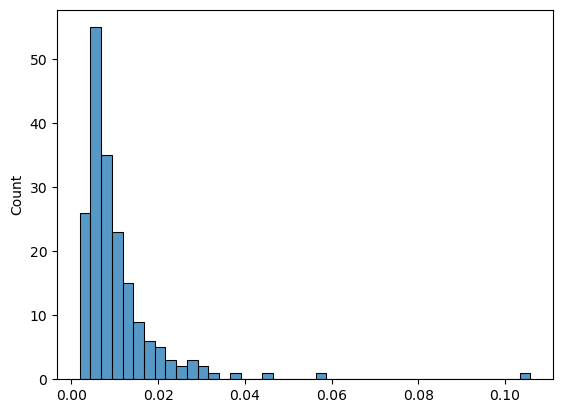

In [32]:
sns.histplot(hist_missing_per_sample/gt_historical.shape[0])

<Axes: ylabel='Count'>

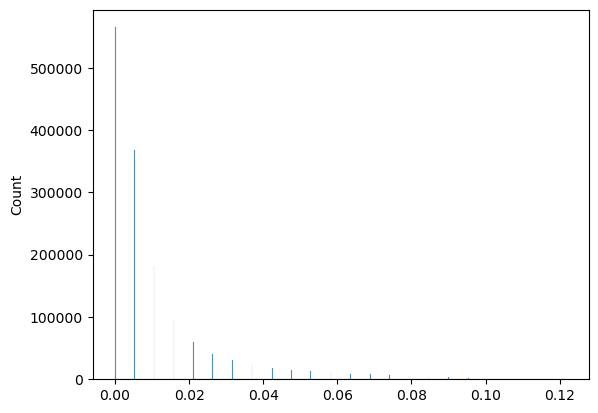

In [33]:
sns.histplot(hist_missing_per_variant/gt_historical.shape[1])

<Axes: ylabel='Count'>

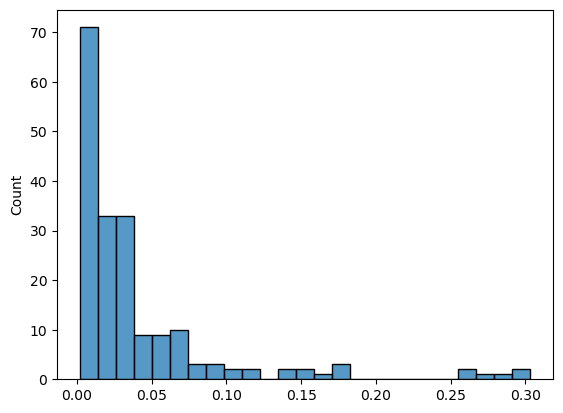

In [34]:
sns.histplot(modern_missing_per_sample/gt_modern.shape[0])

<Axes: ylabel='Count'>

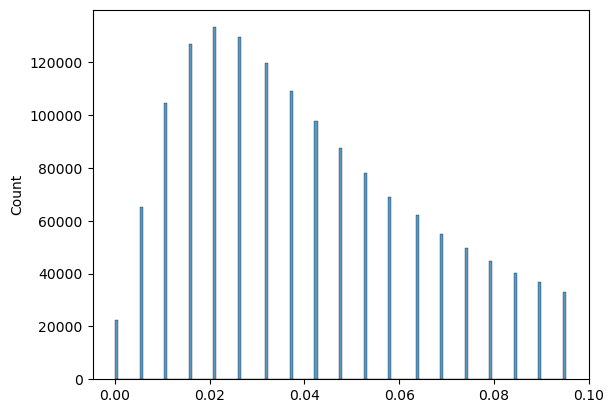

In [35]:
sns.histplot(modern_missing_per_variant/gt_modern.shape[1])

In [13]:
# Convert genotype arrays to allele counts
ac_historical = gt_historical.count_alleles()
ac_modern = gt_modern.count_alleles()

In [14]:
## make sure there are no multiallelic sites 

In [15]:
n_alt_alleles = (ac_historical[:, 2:] > 0).sum(axis=1)

In [16]:
(n_alt_alleles >1).sum()

0

In [17]:
n_alt_alleles = (ac_modern[:, 2:] > 0).sum(axis=1)

In [18]:
(n_alt_alleles >1).sum()

0

In [19]:
# Concatenate across samples
gt_combined = allel.GenotypeArray(
    np.concatenate([gt_historical, gt_modern], axis=1)
)


In [22]:
#gt_combined is the full dataset we will work with 

because we are trying to estimate differentiation metrics, we want to assume that there are 2 populations, a historical and a modern one, and each subpopulation contains 189 individuals 


In [23]:
n_hist = gt_historical.shape[1]
n_mod = gt_modern.shape[1]

subpops = [list(range(n_hist)), list(range(n_hist, n_hist + n_mod))]


In [24]:
## naming the subpops, we will need this for allel usage
subpops = {
    'historical': list(range(n_hist)),
    'modern': list(range(n_hist, n_hist + n_mod))
}


In [25]:
gt_combined.shape

(1448536, 378, 2)

In [26]:
ac_combined = gt_combined.count_alleles()

Also to make the dataset more managable and to avoid spurious metrics and resutls from hihgly correlated allels we will do 2 more extra filters: MAF (minor allele freq) and LD (correlation across snps)


In [27]:
## calcualte maf
maf = ac_combined.to_frequencies()

In [28]:
## calcualting maf, wither low or high end is the same since 
## he have alternative and reference allele
maf_filter_2d = (maf > 0.05) & (maf < 0.95) 

In [29]:
maf_mask = maf_filter_2d.any(axis=1)

In [30]:
len(maf_mask)

1448536

In [31]:
## for filtering 
gn = gt_combined.to_n_alt()  

In [32]:
## apply the mask 
gn_filt = gn[maf_mask, :]

In [33]:
# Prune variants in LD (e.g., r² > 0.8 in 100 variant window)
loc_unlinked = allel.locate_unlinked(gn_filt, size=100, step=20, threshold=0.8)

In [34]:
# Final mask, apply 
final_mask = maf_mask.copy()
final_mask[maf_mask] = loc_unlinked  # apply LD mask only where MAF passed

In [35]:
## this is now our final dataset 
gt_final = gt_combined[final_mask, :]
positions_final = historical['variants/POS'][final_mask]
chroms_final = historical['variants/CHROM'][final_mask]

In [ ]:
# Weir & Cockerham fst calculation 

In [270]:
## now we will calcualte fst between the 2 subpopulations we defined 
# per snp
fst_per_snp, _, _ = allel.weir_cockerham_fst(gt_final, subpops)


In [202]:
## make sure snps and the posiitons array have the same shape
fst_per_snp.shape

(247151, 2)

In [206]:
positions_final.shape

(247151,)

In [207]:
## extract the actual fst value
fst_values = fst_per_snp[:, 0]

In [208]:
fst_values.shape

(247151,)

In [218]:
import numpy as np
import pandas as pd

# Wrap into a dataframe so we can visualize 
df = pd.DataFrame({
    'chrom': chroms_final,
    'pos': positions_final,
    'fst': fst_values
})

df['chrom'] = df['chrom'].astype(str)
df['chrom_numeric'] = df['chrom'].astype('category').cat.codes
df = df.sort_values(['chrom_numeric', 'pos'])


In [219]:
## here we will need to create an 'offset' for visualziation so that every chromosome is separated 
# Get the max position per chromosome
chrom_max = df.groupby('chrom_numeric')['pos'].max()

# Compute cumulative offsets with padding
offsets = chrom_max.cumsum().shift(fill_value=0)
offset_dict = offsets.to_dict()

# Add cumulative position column
df['pos_cum'] = df['pos'] + df['chrom_numeric'].map(offset_dict)


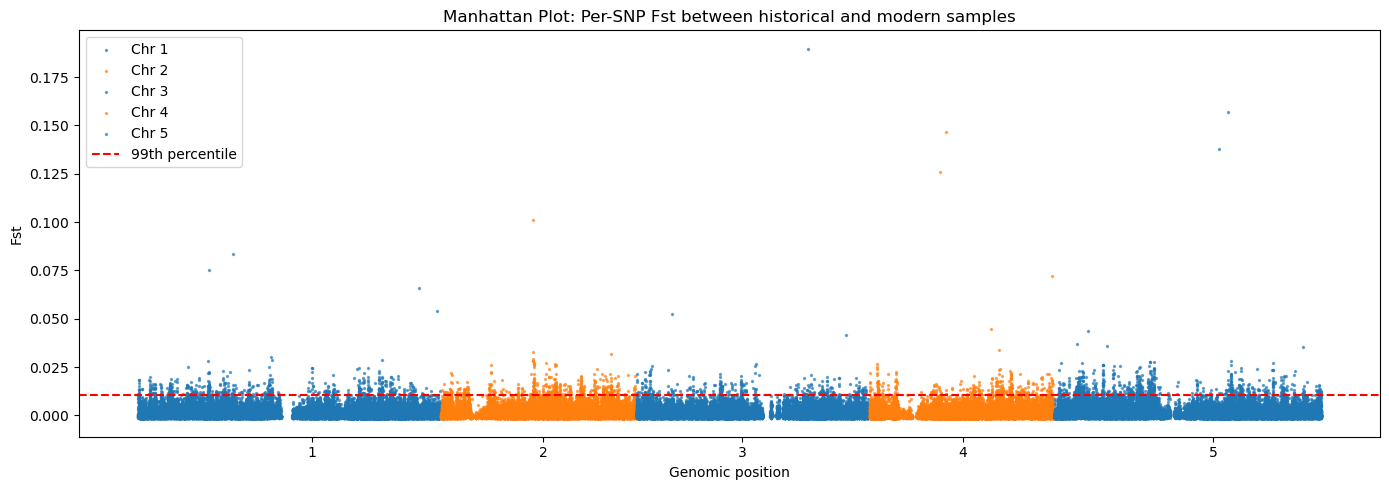

In [220]:
plt.figure(figsize=(14, 5))
colors = ['#1f77b4', '#ff7f0e']

for i, (chrom, group) in enumerate(df.groupby('chrom_numeric')):
    plt.scatter(group['pos_cum'], group['fst'], s=2, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')

# Threshold line
threshold = np.nanpercentile(df['fst'], 99)
plt.axhline(threshold, color='red', linestyle='--', label='99th percentile')

# Chromosome ticks
xticks = df.groupby('chrom_numeric')['pos_cum'].median()
xtick_labels = df.groupby('chrom_numeric')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('Fst')
plt.title('Manhattan Plot: Per-SNP Fst between historical and modern samples')
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
## now lets calcualte change in allele frequency 
gt_hist = gt_final[:, :189]
gt_mod = gt_final[:, 189:]

# Convert to allele counts
ac_hist = gt_hist.count_alleles()
ac_mod = gt_mod.count_alleles()

# Alt allele freq (assume biallelic)
af_hist = ac_hist.to_frequencies()[:, 1]
af_mod = ac_mod.to_frequencies()[:, 1]

# Delta AF
delta_af = af_mod - af_hist
abs_delta_af = np.abs(delta_af)


In [225]:
len(abs_delta_af)

247151

In [226]:
df['abs_delta_af'] = abs_delta_af

/tmp/ipykernel_898044/784212228.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


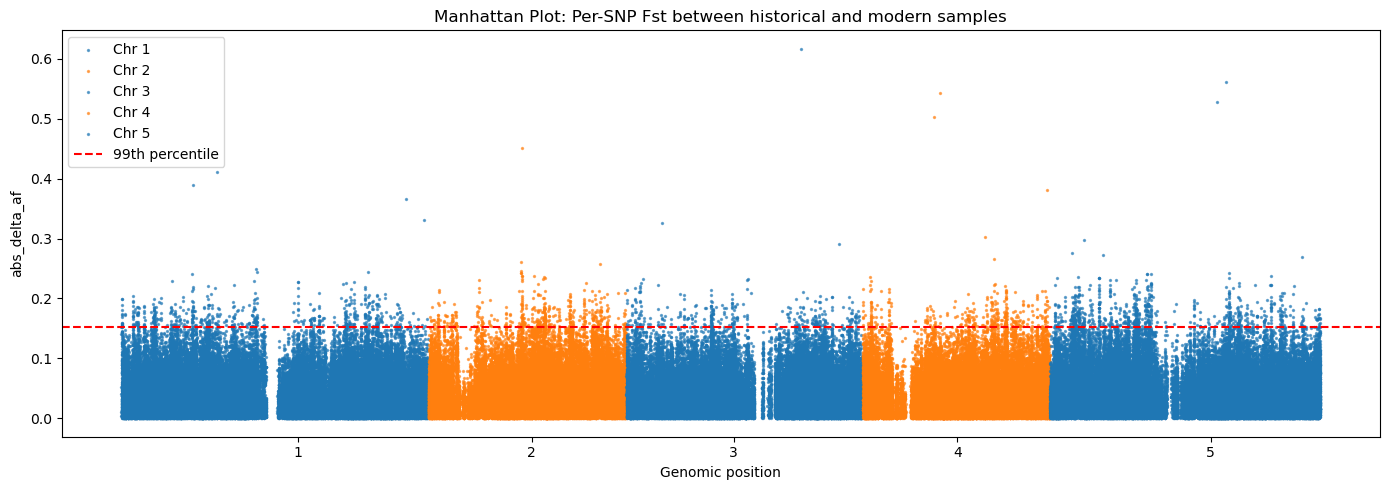

In [227]:
plt.figure(figsize=(14, 5))
colors = ['#1f77b4', '#ff7f0e']

for i, (chrom, group) in enumerate(df.groupby('chrom_numeric')):
    plt.scatter(group['pos_cum'], group['abs_delta_af'], s=2, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')

# Threshold line
threshold = np.nanpercentile(df['abs_delta_af'], 99)
plt.axhline(threshold, color='red', linestyle='--', label='99th percentile')

# Chromosome ticks
xticks = df.groupby('chrom_numeric')['pos_cum'].median()
xtick_labels = df.groupby('chrom_numeric')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('abs_delta_af')
plt.title('Manhattan Plot: Per-SNP Fst between historical and modern samples')
plt.legend()
plt.tight_layout()
plt.show()


In [228]:
## heterozigocity 
he_hist = 2 * af_hist * (1 - af_hist)
he_mod = 2 * af_mod * (1 - af_mod)
delta_he = he_mod - he_hist

In [229]:
df['delta_he'] = delta_he

/tmp/ipykernel_898044/4258848981.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


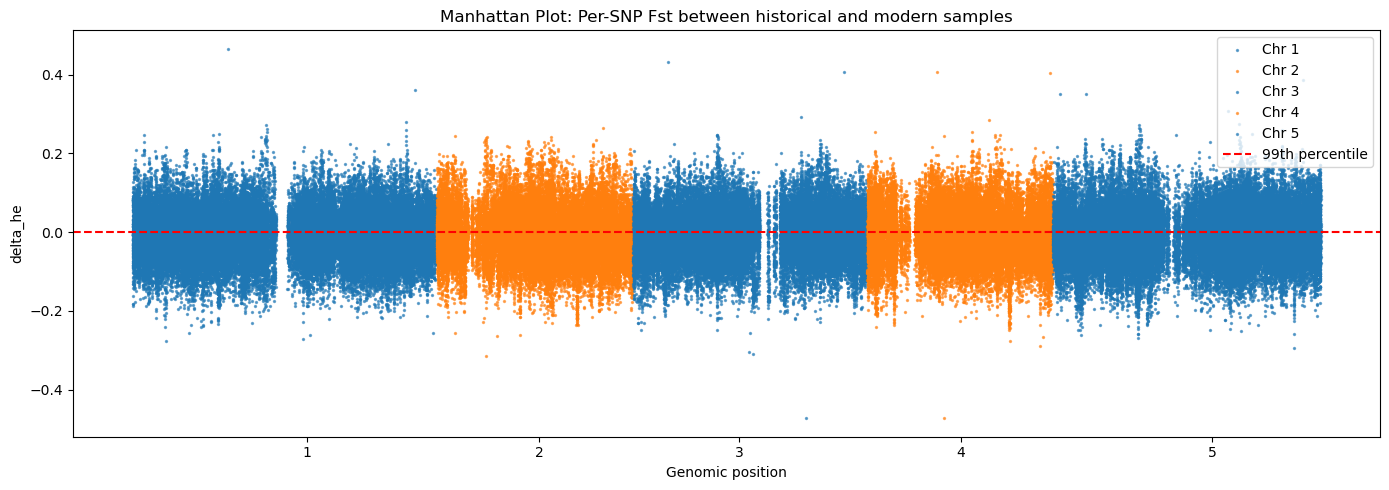

In [231]:
plt.figure(figsize=(14, 5))
colors = ['#1f77b4', '#ff7f0e']

for i, (chrom, group) in enumerate(df.groupby('chrom_numeric')):
    plt.scatter(group['pos_cum'], group['delta_he'], s=2, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')

# Threshold line

plt.axhline(0, color='red', linestyle='--', label='99th percentile')

# Chromosome ticks
xticks = df.groupby('chrom_numeric')['pos_cum'].median()
xtick_labels = df.groupby('chrom_numeric')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('delta_he')
plt.title('Manhattan Plot: Per-SNP Fst between historical and modern samples')
plt.legend()
plt.tight_layout()
plt.show()


In [268]:
df.to_csv('filtered_af_change_hist_mod.csv',index=None)

In [ ]:
## now lets calculate pi (diversity) to see if there is a lowering in diversity 
## maybe around an area of the genome that has been under selection 

In [36]:
import numpy as np
import pandas as pd
import allel

# Wrap all into a DataFrame for grouping
df_gt = pd.DataFrame({
    'chrom': chroms_final,
    'pos': positions_final
})


In [50]:
## ompute pi in a window based 
window_size = 5000
results = []

for chrom in df_gt['chrom'].unique():
    # Subset by chromosome
    chrom_mask = df_gt['chrom'] == chrom
    pos_sub = df_gt.loc[chrom_mask, 'pos'].values
    ac_hist_sub = ac_hist[chrom_mask, :]
    ac_mod_sub = ac_mod[chrom_mask, :]

    pi_hist, win_coords, _ , _ = allel.windowed_diversity(pos_sub, ac_hist_sub, size=window_size)    
    pi_mod, _ , _, _ = allel.windowed_diversity(pos_sub, ac_mod_sub, size=window_size)
    delta_pi = pi_mod - pi_hist

    df_chr = pd.DataFrame(win_coords, columns=['start', 'end'])
    df_chr['chrom'] = chrom
    df_chr['pi_hist'] = pi_hist
    df_chr['pi_mod'] = pi_mod
    df_chr['delta_pi'] = delta_pi

    results.append(df_chr)


In [51]:
df_pi_all = pd.concat(results).reset_index(drop=True)

In [52]:
#df_pi_all.to_csv('df_pi_hist_vs_modern.csv',index=None)

In [53]:
gene_df = pd.read_csv('genes_df.csv')

In [54]:
import numpy as np
import pandas as pd

# 1. Ensure chromosome is string and create numeric codes
df_pi_all['chrom'] = df_pi_all['chrom'].astype(str)
df_pi_all['chrom_numeric'] = df_pi_all['chrom'].astype('category').cat.codes

# 2. Sort by chrom and window start
df_pi_all = df_pi_all.sort_values(['chrom_numeric', 'start'])

# 3. Compute max end per chromosome for offset
max_ends = df_pi_all.groupby('chrom_numeric')['end'].max()
offsets = max_ends.cumsum().shift(fill_value=0)
offset_dict = offsets.to_dict()

# 4. Add cumulative position column
df_pi_all['start_cum'] = df_pi_all['start'] + df_pi_all['chrom_numeric'].map(offset_dict)


In [55]:
df_pi_all['mean']  = (df_pi_all['start'] + df_pi_all['end'] )/2

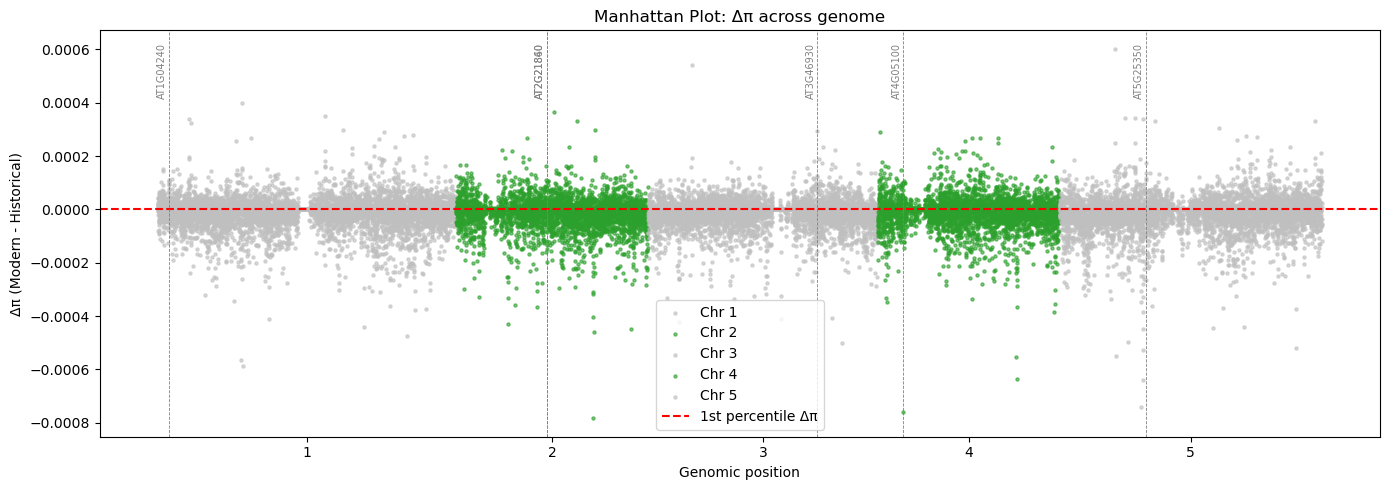

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df_pi_all.groupby('chrom_numeric')):
    plt.scatter(group['start_cum'], group['delta_pi'], s=5, alpha=0.6,
                color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')

# Optional threshold line
plt.axhline(0, color='red', linestyle='--', label='1st percentile Δπ')

# Chromosome tick labels
xticks = df_pi_all.groupby('chrom_numeric')['start_cum'].median()
xtick_labels = df_pi_all.groupby('chrom_numeric')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('Δπ (Modern - Historical)')
plt.title('Manhattan Plot: Δπ across genome')
plt.legend()
plt.tight_layout()

# Draw grey vertical lines and add gene ID labels
for _, row in gene_df.iterrows():
    chrom = str(row['chrom'])
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    filter_df = df_pi_all[(df_pi_all['chrom'] == chrom) & (df_pi_all['mean']>=gene_start-1000) & (df_pi_all['mean']<=gene_ends+1000)]
    gene_pos_cum = filter_df.sample(1)['start_cum'].values[0]

    # Plot vertical line
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df_pi_all['delta_pi'].max() * 0.7, gene_id,
             rotation=90, 
             fontsize=7, color='grey', ha='center')

plt.show()


In [57]:
gene_df

,gene_id,chrom,start,end,length
0,AT1G04240,1,1128149,1129689,1540
1,AT2G21840,2,9307024,9310358,3334
2,AT2G21860,2,9318122,9320024,1902
3,AT3G46930,3,17285565,17288077,2512
4,AT4G05100,4,2618372,2619947,1575
5,AT5G25350,5,8794252,8797349,3097


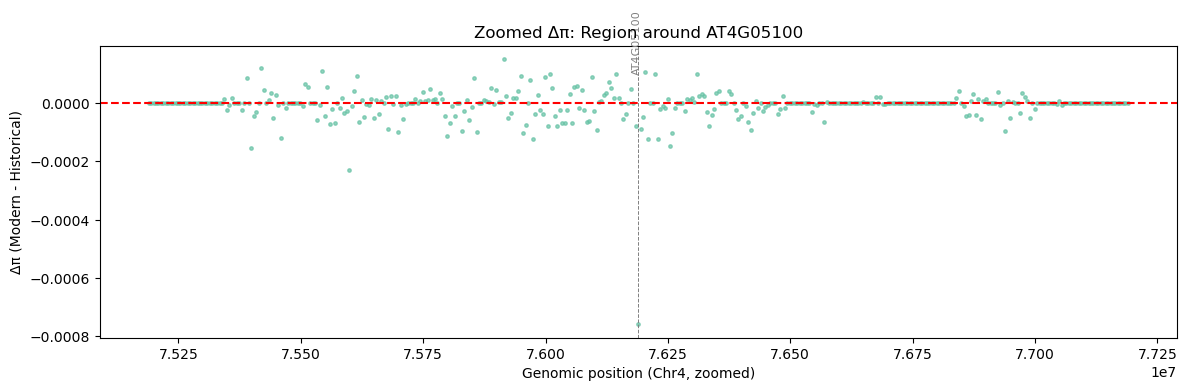

In [67]:
import matplotlib.pyplot as plt

# Define zoom window (buffer added around genes)
chrom = "4"
start_zoom = 2618372 - 1000000  # 10kb before
end_zoom = 2619947 + 1000000    # 10kb after

# Filter DataFrame for this region
zoom_df = df_pi_all[
    (df_pi_all['chrom'] == chrom) &
    (df_pi_all['mean'] >= start_zoom) &
    (df_pi_all['mean'] <= end_zoom)
]

plt.figure(figsize=(12, 4))
plt.scatter(zoom_df['start_cum'], zoom_df['delta_pi'], s=6, alpha=0.7, color='#66c2a5')

# Reference line
plt.axhline(0, color='red', linestyle='--', label='Δπ = 0')

# Add gene vertical lines and labels
for _, row in gene_df.iterrows():
    if str(row['chrom']) == chrom and row['start'] >= start_zoom and row['end'] <= end_zoom:
        gene_start = row['start']
        gene_end = row['end']
        gene_id = row['gene_id']
        
        # Find closest position for cumulative coordinate
        gene_pos_cum = zoom_df[(zoom_df['mean'] >= gene_start - 500) & (zoom_df['mean'] <= gene_end + 500)]['start_cum'].median()
        plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.7)
        plt.text(gene_pos_cum - 2000, zoom_df['delta_pi'].max() * 0.7, gene_id,
                 rotation=90, fontsize=8, color='grey', ha='center')

plt.xlabel("Genomic position (Chr4, zoomed)")
plt.ylabel("Δπ (Modern - Historical)")
plt.title("Zoomed Δπ: Region around AT4G05100")
plt.tight_layout()
plt.show()


In [63]:
gene_df

,gene_id,chrom,start,end,length
0,AT1G04240,1,1128149,1129689,1540
1,AT2G21840,2,9307024,9310358,3334
2,AT2G21860,2,9318122,9320024,1902
3,AT3G46930,3,17285565,17288077,2512
4,AT4G05100,4,2618372,2619947,1575
5,AT5G25350,5,8794252,8797349,3097


gene_id    AT5G25350
chrom              5
start        8794252
end          8797349
length          3097
Name: 5, dtype: object


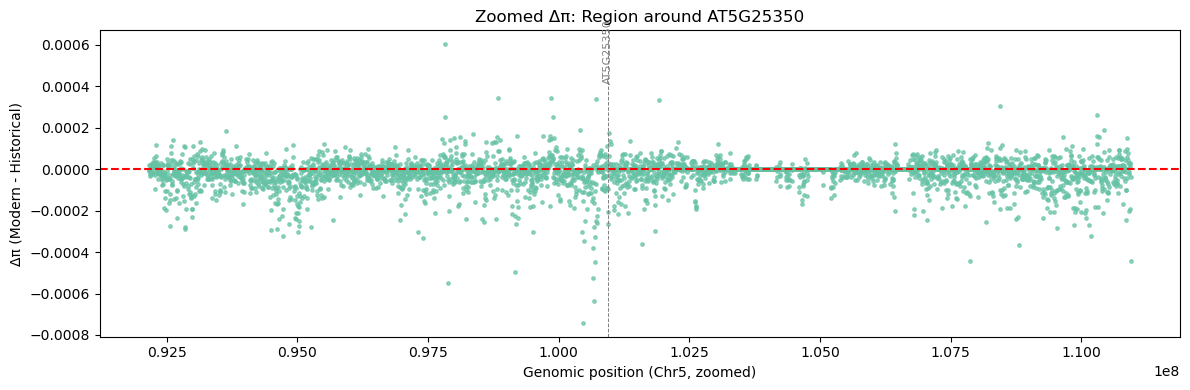

In [65]:
import matplotlib.pyplot as plt

# Define zoom window (buffer added around genes)
chrom = "5"
start_zoom = 8794252 - 10000000  # 10kb before
end_zoom = 8797349 + 10000000    # 10kb after

# Filter DataFrame for this region
zoom_df = df_pi_all[
    (df_pi_all['chrom'] == chrom) &
    (df_pi_all['mean'] >= start_zoom) &
    (df_pi_all['mean'] <= end_zoom)
]

plt.figure(figsize=(12, 4))
plt.scatter(zoom_df['start_cum'], zoom_df['delta_pi'], s=6, alpha=0.7, color='#66c2a5')

# Reference line
plt.axhline(0, color='red', linestyle='--', label='Δπ = 0')

# Add gene vertical lines and labels
for _, row in gene_df.iterrows():
    if str(row['chrom']) == chrom and row['start'] >= start_zoom and row['end'] <= end_zoom:
        print(row)
        gene_start = row['start']
        gene_end = row['end']
        gene_id = row['gene_id']
        
        # Find closest position for cumulative coordinate
        gene_pos_cum = zoom_df[(zoom_df['mean'] >= gene_start - 5000) & (zoom_df['mean'] <= gene_end + 5000)]['start_cum'].median()
        plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.7)
        plt.text(gene_pos_cum - 2000, zoom_df['delta_pi'].max() * 0.7, gene_id,
                 rotation=90, fontsize=8, color='grey', ha='center')

plt.xlabel("Genomic position (Chr5, zoomed)")
plt.ylabel("Δπ (Modern - Historical)")
plt.title("Zoomed Δπ: Region around AT5G25350")
plt.tight_layout()
plt.show()
